# Simple Model vs. SDSS photometric classification

This notebook compares the simple model (comparing the white PSF flux to the white Kron flux from PS1 photometry) to the independent SDSS test set. 

The SDSS data are assumed to have perfect labels from spectroscopy, and we compare the simple model to the SDSS photometric classification, which considers all sources with `psfMag - cModelMag > 0.145` to be stars.

In [57]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,zoomed_inset_axes

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

%matplotlib notebook

In [2]:
sdss = fits.getdata("sdssSP_MLfeats_adamamiller1.fit")

From the simple model we find that the optimal FoM is $a = 0.9295$

In [15]:
a = 0.9295

In [8]:
# metrics for the simple model

def calc_distance(a, x, y): # model: y = ax
    a = np.array(a)
    model = (a*x).astype(float)
    wd = (y-model)/np.sqrt(1 + a**2)
    return np.array(wd)

def calc_accuracy(a, flux1, flux2, true_class):
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    pred_class = np.array((np.sign(delta)+1)/2, dtype = int)    # psf = kron >> gal
    acc = accuracy_score(true_class, pred_class)
    return acc

def calc_roc_curve(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)    
    return fpr, tpr, thre

In [53]:
spec_galaxies = np.where(sdss["class"] == 'GALAXY')
spec_labels = np.ones_like(sdss["type"], dtype=int)
spec_labels[spec_galaxies] = 0
phot_labels = np.ones_like(sdss["type"], dtype=int)*-99
phot_labels[np.where(sdss["type"] == 3)] = 0
phot_labels[np.where(sdss["type"] == 6)] = 1

ps_dist = calc_distance(a, sdss["wwKronFlux"], sdss["wwPSFFlux"])
simple_labels = (np.sign(ps_dist).astype(int) + 1)/2

in_common = ( ((sdss["type"] == 3) | (sdss["type"] == 6))   # star or galaxy in SDSS
             & (np.isfinite(ps_dist)) )    # is detected in PS1

print("There are {:d} sources in PS1 and SDSS with spectra".format(sum(in_common)))

print("The accuracy of the SDSS photometric classifier is: {:.4f}".format(accuracy_score(spec_labels[in_common], phot_labels[in_common])))
print("The accuracy of the PS1 photometric classifier is: {:.4f}".format(accuracy_score(spec_labels[in_common], simple_labels[in_common])))

There are 3821520 sources in PS1 and SDSS with spectra
The accuracy of the SDSS photometric classifier is: 0.9597
The accuracy of the PS1 photometric classifier is: 0.9547


<IPython.core.display.Javascript object>


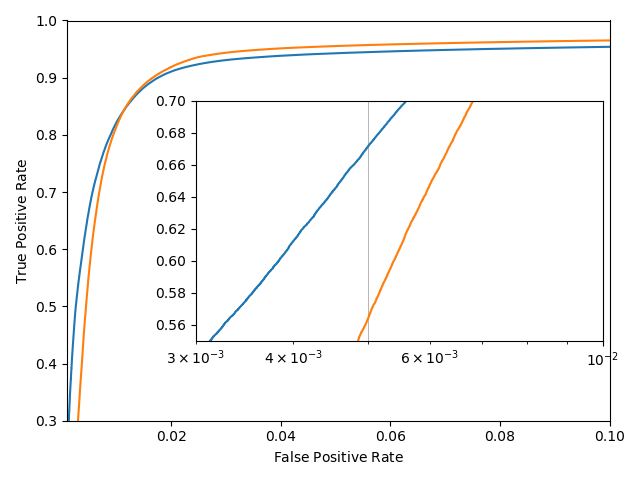

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [59]:
ps_fpr, ps_tpr, ps_thre = roc_curve(spec_labels[in_common], ps_dist[in_common])
sdss_fpr, sdss_tpr, sdss_thre = roc_curve(spec_labels[in_common], sdss["countRatio"][in_common])


fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

ax.plot(ps_fpr, ps_tpr)
ax.plot(sdss_fpr, sdss_tpr)
axins.plot(ps_fpr, ps_tpr)
axins.plot(sdss_fpr, sdss_tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,.1)
ax.set_ylim(.3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()

In [49]:
sum(np.isnan(ps_dist[in_common]))

7113

In [52]:
np.isfinite(ps_dist)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [6]:
sdss.columns

ColDefs(
    name = 'class'; format = '6A'; dim = '(1)'
    name = 'sourceType'; format = '22A'; dim = '(1)'
    name = 'z'; format = '1D'; dim = '(1)'
    name = 'cModelMag_r'; format = '1D'; dim = '(1)'
    name = 'gminusi'; format = '1D'; dim = '(1)'
    name = 'type'; format = '1I'; null = -99; dim = '(1)'
    name = 'countRatio'; format = '1D'; dim = '(1)'
    name = 'raStack'; format = '1D'; dim = '(1)'
    name = 'decStack'; format = '1D'; dim = '(1)'
    name = 'nDetections'; format = '1I'; null = -99; dim = '(1)'
    name = 'qualityFlag'; format = '1B'; dim = '(1)'
    name = 'primaryDetection'; format = '1B'; dim = '(1)'
    name = 'bestDetection'; format = '1B'; dim = '(1)'
    name = 'gpsfMajorFWHM'; format = '1D'; dim = '(1)'
    name = 'gpsfMinorFWHM'; format = '1D'; dim = '(1)'
    name = 'gpsfCore'; format = '1D'; dim = '(1)'
    name = 'gpsfLikelihood'; format = '1D'; dim = '(1)'
    name = 'gpsfQf'; format = '1D'; dim = '(1)'
    name = 'gpsfQfPerfect'; format = '1D';